# XPER

In [4]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv("../Data/black_box_3_data.csv")

In [6]:
X = df.drop(columns=["Default (y)", "Pred_default (y_hat)", "PD", "Group"])
y = df["Default (y)"]


In [7]:
scaler = joblib.load("../Models/MLP_scaler_only.pkl")

X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:
model = joblib.load("../Models/MLP_model_only.pkl")

In [9]:
from XPER.compute.Performance import ModelPerformance

XPER_ = ModelPerformance(X_train, y_train.values, X_test, y_test.values, model)

In [10]:
PM = XPER_.evaluate(["AUC"])
print("Performance Metrics: ", round(PM, 3))

Performance Metrics:  0.82


In [8]:
XPER_values = XPER_.calculate_XPER_values(["AUC"], kernel=True)


Performing Computation:   0%|          | 0/1 [00:00<?, ?it/s]

2078


In [11]:
# Use a smaller test set (for testing purposes)
X_test_small, _, y_test_small, _ = train_test_split(
    X_test, y_test, test_size=0.9, random_state=42
)

In [12]:
XPER_ = ModelPerformance(
    X_train, y_train.values, X_test_small, y_test_small.values, model
)
# XPER_values = XPER_.calculate_XPER_values(
#     ["AUC"], kernel=False, execution_type="ProcessPoolExecutor"
# )


In [2]:
import cProfile

cProfile.run('XPER_.calculate_XPER_values(["AUC"], kernel=False)')


Performing computation:   0%|          | 0/15 [00:00<?, ?it/s]

# Permutation Importance

In [4]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib

In [2]:
pipeline = joblib.load("../Models/MLP_pipeline.pkl")

In [3]:
df = pd.read_csv("../Data/black_box_3_data.csv")

X = df.drop(columns=["Default (y)", "Pred_default (y_hat)", "PD", "Group"])

y = df["Default (y)"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

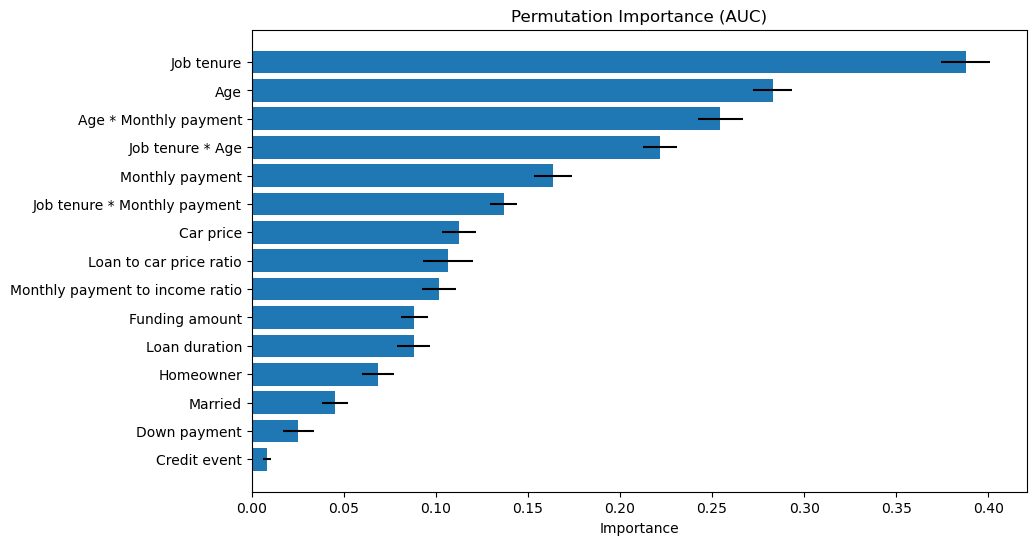

In [10]:
# Perform permutation importance on the test set
perm_importance = permutation_importance(
    pipeline, X_test, y_test, scoring="roc_auc", n_repeats=10, random_state=42
)

# Get feature importances and their standard deviations
importance_means = perm_importance.importances_mean
importance_std = perm_importance.importances_std
features = np.array(X_test.columns)

# Sort by importance in descending order
indices = np.argsort(importance_means)[::-1]  # Sort in descending order

# Plot the results
plt.figure(figsize=(10, 6))
plt.title("Permutation Importance (AUC)")
plt.barh(
    range(len(indices)),
    importance_means[indices],
    xerr=importance_std[indices],
    align="center",
)
plt.yticks(range(len(indices)), features[indices])
plt.gca().invert_yaxis()  # Ensures the most important feature is at the top
plt.xlabel("Importance")
plt.show()


## Comparison with SHAP

# Comparison of SHAP Values and Permutation Importance

Both the SHAP plot and the Permutation Importance plot you generated provide insights into feature importance, but they offer different perspectives on how the model interprets features.

### 1. SHAP Summary Plot (Feature Impact on Predictions):
- **Purpose**: SHAP explains the contribution of each feature to individual predictions.
- **Interpretation**: It measures the average impact of a feature on the model’s output (i.e., how much the feature drives the prediction towards a certain class).

#### Key Insights:
- **Job tenure, Job tenure * Age, and Age** have the highest SHAP values, meaning they significantly influence individual predictions. These features have the most substantial effect on shifting the model's output either towards or away from predicting a loan default.
- **Interaction terms** like *Job tenure * Age* and *Age * Monthly payment* are also critical, showing how these combined features impact predictions.
- **Credit event** and **Down payment** have relatively little influence on individual predictions, as indicated by their near-zero SHAP values.

### 2. Permutation Importance (Feature Impact on Model Performance):
- **Purpose**: Permutation Importance measures the effect of randomly shuffling a feature’s values on the overall model performance (AUC in this case). It identifies which features are critical to maintaining the model’s predictive accuracy.
- **Interpretation**: This metric shows how much the performance metric (AUC) drops when a feature is permuted (shuffled).

#### Key Insights:
- **Job tenure** and **Age** remain the most critical features, showing the largest drop in AUC when shuffled. This consistency suggests that these features not only affect individual predictions (as seen in SHAP) but are also central to the model’s overall predictive ability.
- Interaction terms like **Age * Monthly payment** and **Job tenure * Age** still have a substantial impact, though **Monthly payment** itself ranks higher than in the SHAP plot.
- **Credit event** and **Down payment** have the least importance, as shuffling these features barely impacts the model’s performance.

### Similarities:
- Both methods rank **Job tenure** and **Age** as highly important features.
- Interaction terms such as **Job tenure * Age** and **Age * Monthly payment** also feature prominently in both plots, showing that the interactions between these features are important for both individual predictions and overall model performance.

### Differences:
- **Monthly payment** is more important in the Permutation Importance plot than in the SHAP plot. This suggests that while the Monthly payment feature does not drastically shift individual predictions, the model relies heavily on it for overall performance.
- **Credit event** and **Down payment** are shown to have little influence in both, but their impact is even lower in the SHAP plot, indicating that these features hardly affect individual predictions.

### Conclusion:
- **Key Drivers**: Both methods identify **Job tenure** and **Age** as the primary drivers of the model’s predictive power.
- **Feature Interactions**: The SHAP plot highlights interaction terms (e.g., *Job tenure * Age*), showing their critical role in individual predictions, while the Permutation Importance plot emphasizes the features that maintain the overall model’s predictive accuracy.

Using both methods provides a more comprehensive understanding of how the model works, balancing insights into individual-level impacts (SHAP) and model-wide performance contributions (Permutation Importance).
